In [11]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
140,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
141,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed



=== 總結報告 ===
累積買入金額：661,551.00 元
淨現金流：-420,402.00 元
實際淨投入資金：420,402.00 元
最終組合市值（現有持股）：674,815.81 元
總獲利：254,413.81 元
總獲利百分比：60.52%
XIRR: 20.37%
最終累積績效: 60.52%
每日 IRR: 0.0438%
年化 IRR: 11.67%
夏普值: 0.6950
最大回撤: -25.43%

=== 投資組合股票明細 ===
+----------+------------+----------------+---------+---------------+--------+----------+------------+
| Symbol   | Name       |   Quantity_now |   Price |   Price_Total |   Cost |     Gain |    Gain(%) |
|----------+------------+----------------+---------+---------------+--------+----------+------------|
| 0050     | 0050       |              0 |  nan    |           nan |  21187 |    349   |   1.64724  |
| 2330     | 台積       |              0 |  nan    |           nan |  39876 |   3004   |   7.53335  |
| 2376     | 技嘉       |            100 |  258.5  |         25850 |   8809 |  17041   | 193.45     |
| 006208   | 006208     |           4566 |  113.15 |        516643 | 364822 | 151821   |  41.6151   |
| 2884     | 玉山金     |              0 |  nan    |       

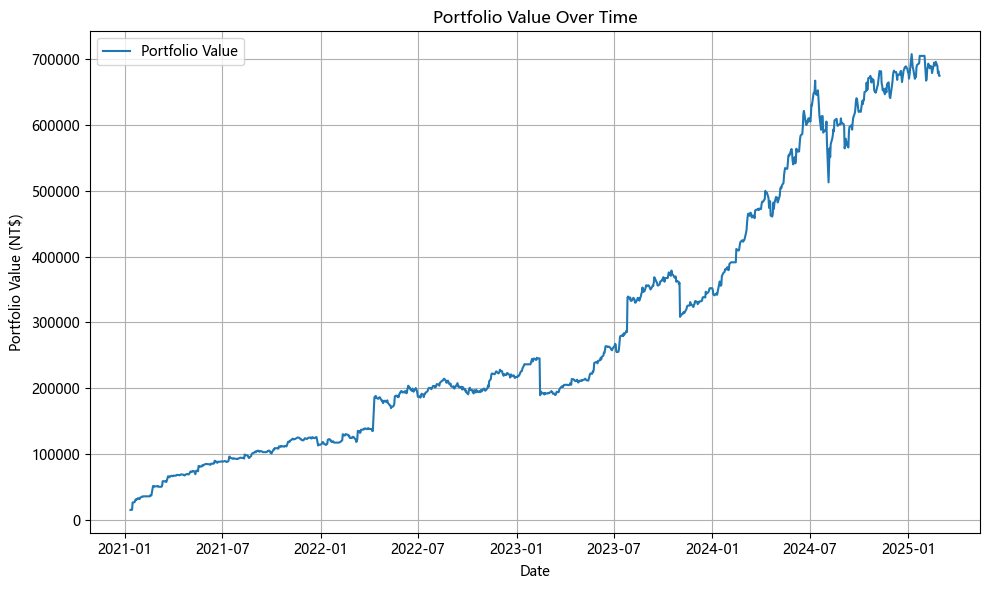

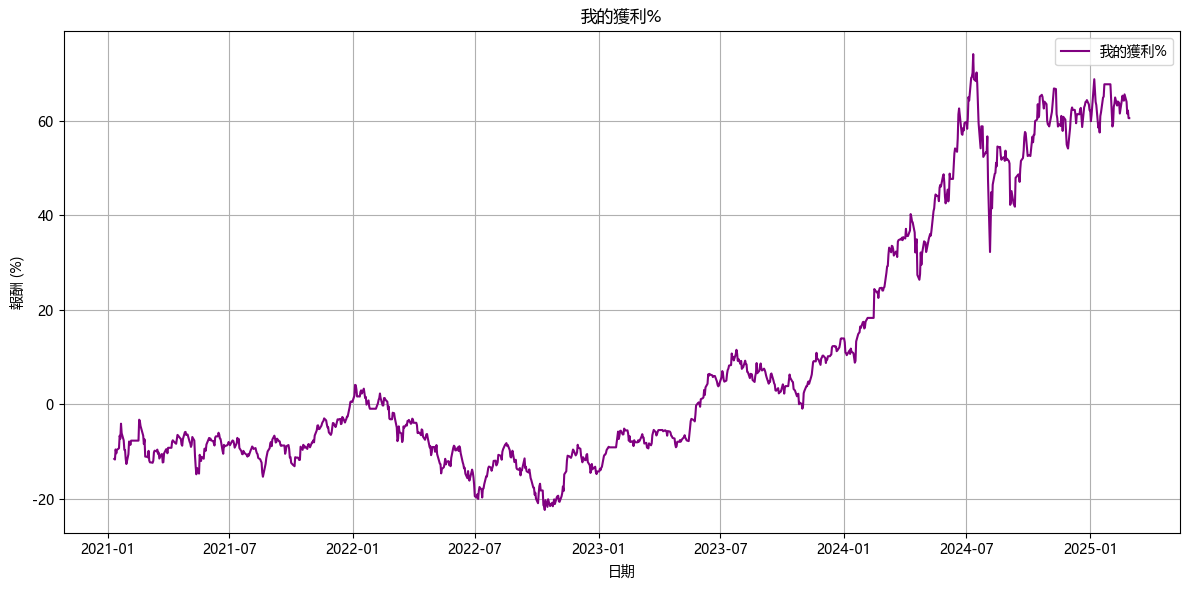

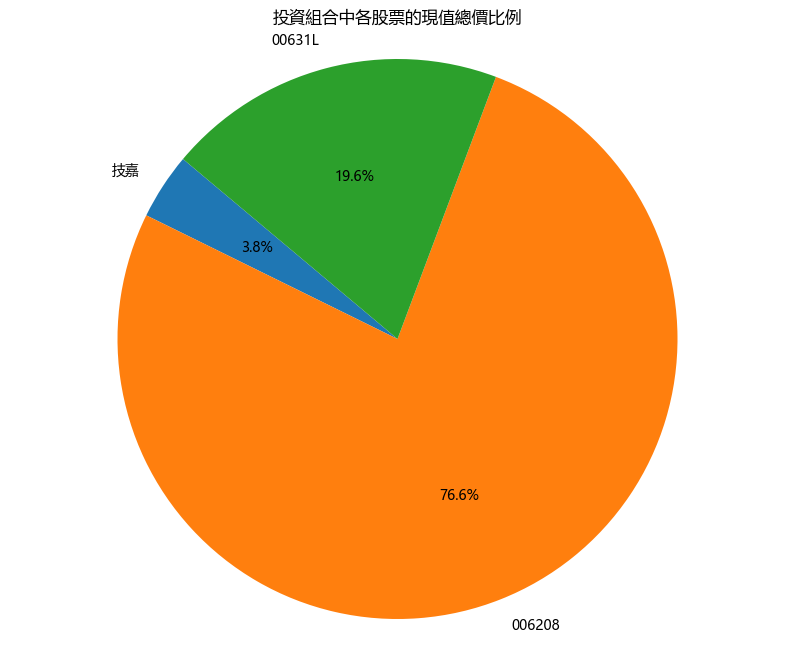

2023/2/10 到 2023/2/15 的市值:
2023-02-10    245303.560005
2023-02-13    245381.940430
2023-02-14    189410.041023
2023-02-15    192768.622902
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    245303.560005
2023-02-11    245303.560005
2023-02-12    245303.560005
2023-02-13    245381.940430
2023-02-14    189410.041023
2023-02-15    192768.622902
Freq: D, dtype: float64


In [1]:
%run tw.py

[*********************100%***********************]  6 of 6 completed



=== 總結報告 ===
累積買入金額：35,491.21 元
淨現金流：-18,271.35 元
實際淨投入資金：18,271.35 元
最終組合市值（現有持股）：22,899.14 元
總獲利：4,627.79 元
總獲利百分比：25.33%
XIRR: 14.60%
最終累積績效: 25.33%
每日 IRR: 0.0272%
年化 IRR: 7.10%
夏普值: 0.4885
最大回撤: -65.22%

=== 投資組合股票明細 ===
+----------+--------+----------------+----------+---------------+----------+----------+-----------+
| Symbol   | Name   |   Quantity_now |    Price |   Price_Total |     Cost |     Gain |   Gain(%) |
|----------+--------+----------------+----------+---------------+----------+----------+-----------|
| TQQQ     | TQQQ   |              0 | nan      |        nan    |  6175.88 | 3441.68  |  55.7278  |
| EDV      | EDV    |             61 |  71.7801 |       4378.59 |  4935.46 | -556.874 | -11.2831  |
| TMF      | TMF    |              0 | nan      |        nan    |    57.79 |  -42.06  | -72.7808  |
| VOO      | VOO    |              0 | nan      |        nan    |  3425.97 |  507.63  |  14.8171  |
| SPLG     | SPLG   |             95 |  69.69   |       6620.55 |  5266.8

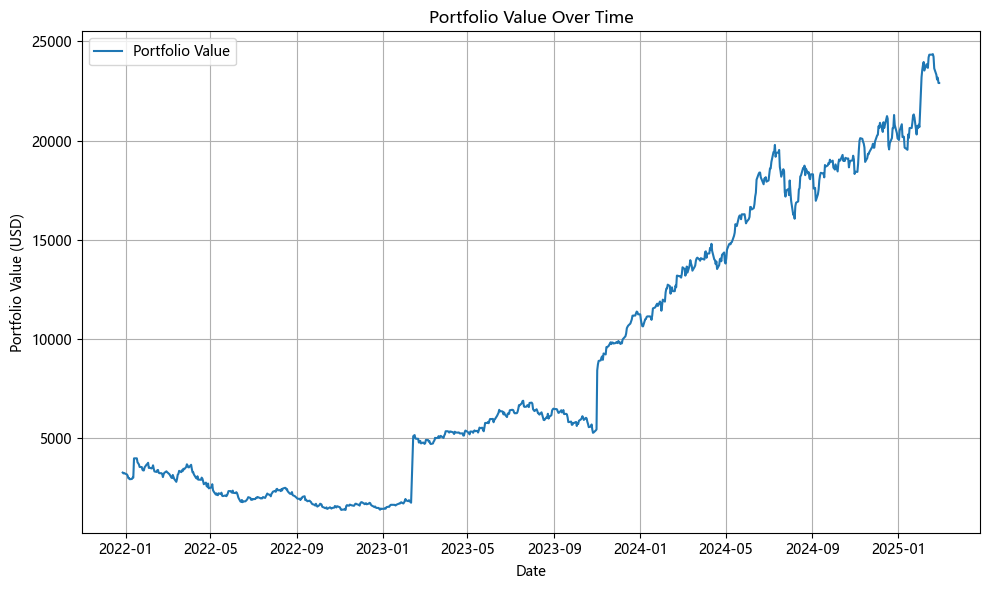

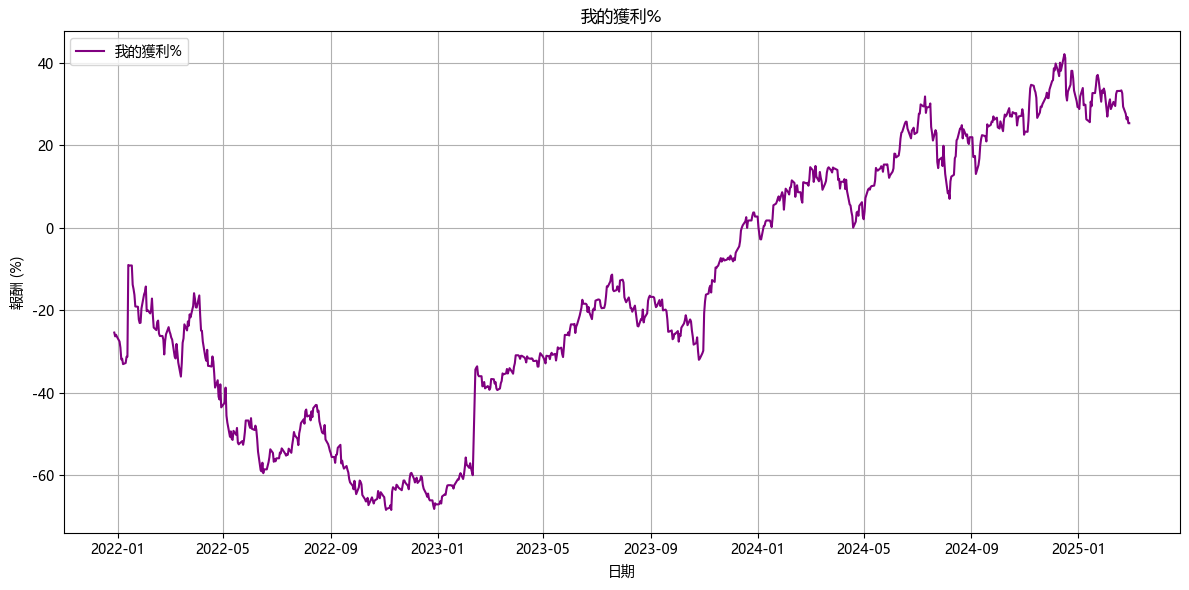

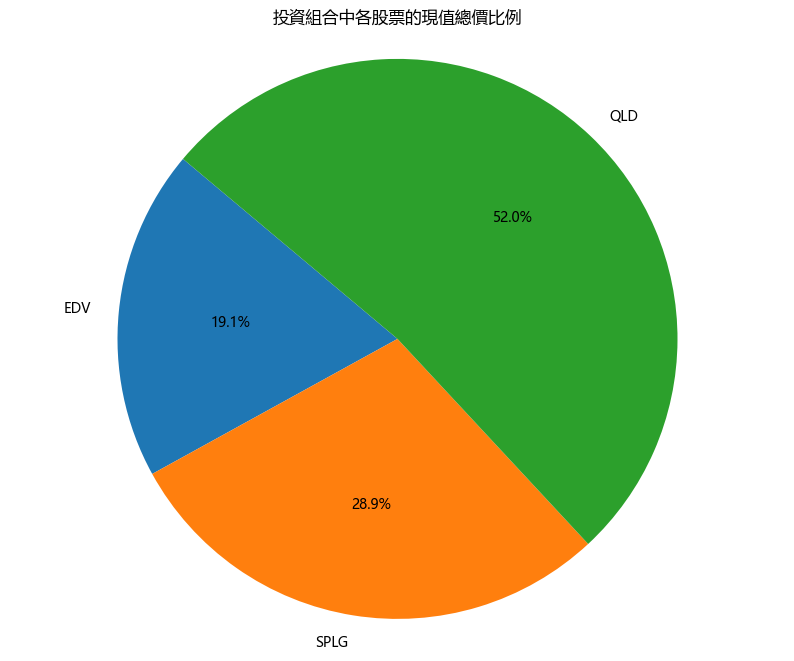

2023/2/10 到 2023/2/15 的市值:
2023-02-10    1744.173964
2023-02-13    5092.296648
2023-02-14    5127.212523
2023-02-15    5152.440790
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    1744.173964
2023-02-11    1744.173964
2023-02-12    1744.173964
2023-02-13    5092.296648
2023-02-14    5127.212523
2023-02-15    5152.440790
Freq: D, dtype: float64


In [14]:
%run us.py

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed



=== 綜合資產配置報告 (單位: USD) ===
累積買入金額：55,628.52 USD
實際淨投入資金：31,068.20 USD
最終組合市值：43,439.68 USD
總獲利：12,371.49 USD
總獲利百分比：39.82%
Sortino Ratio：7.97
Calmar Ratio：0.10
綜合 XIRR: 17.82%

=== 綜合資產配置報告 (單位: TWD) ===
累積買入金額：1,827,508.23 TWD
實際淨投入資金：1,020,652.39 TWD
最終組合市值：1,427,080.52 TWD
總獲利：406,428.13 TWD
總獲利百分比：39.82%
綜合 XIRR: 17.82%

=== 綜合投資組合股票明細 (TWD) ===
+----------+------------+----------------+-----------+---------------+-----------+-------------+-------------+-----------+
| Symbol   | Name       |   Quantity_now |     Price |   Price_Total |      Cost | Gain(USD)   | Gain(TWD)   | Gain(%)   |
|----------+------------+----------------+-----------+---------------+-----------+-------------+-------------+-----------|
| 0050     | 0050       |              0 |   0       |         0     |   644.923 | 10.62       | 349.00      | 1.65%     |
| 2330     | 台積       |              0 |   0       |         0     |  1213.81  | 91.44       | 3,004.00    | 7.53%     |
| 2376     | 技嘉       |           

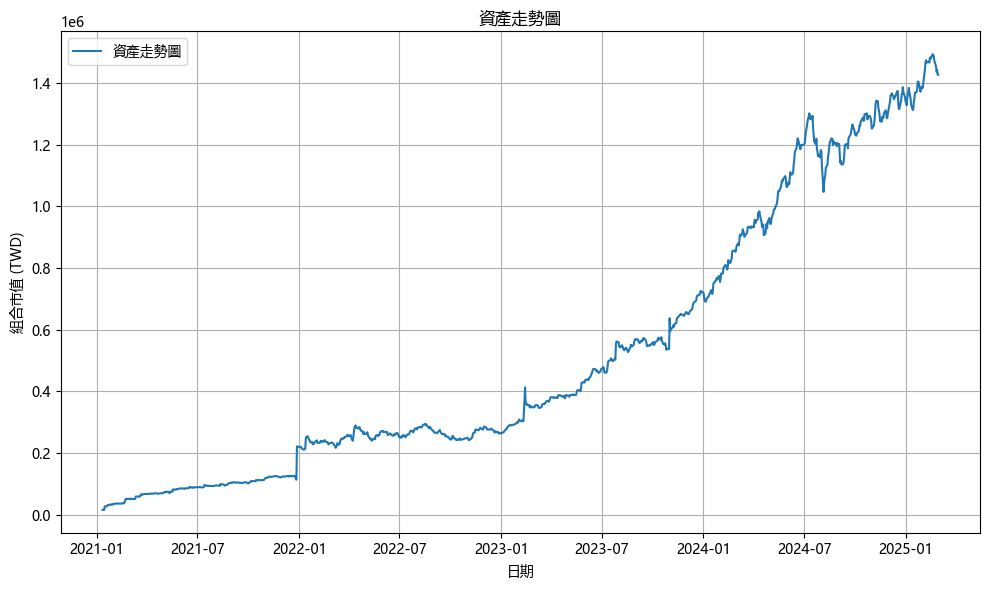

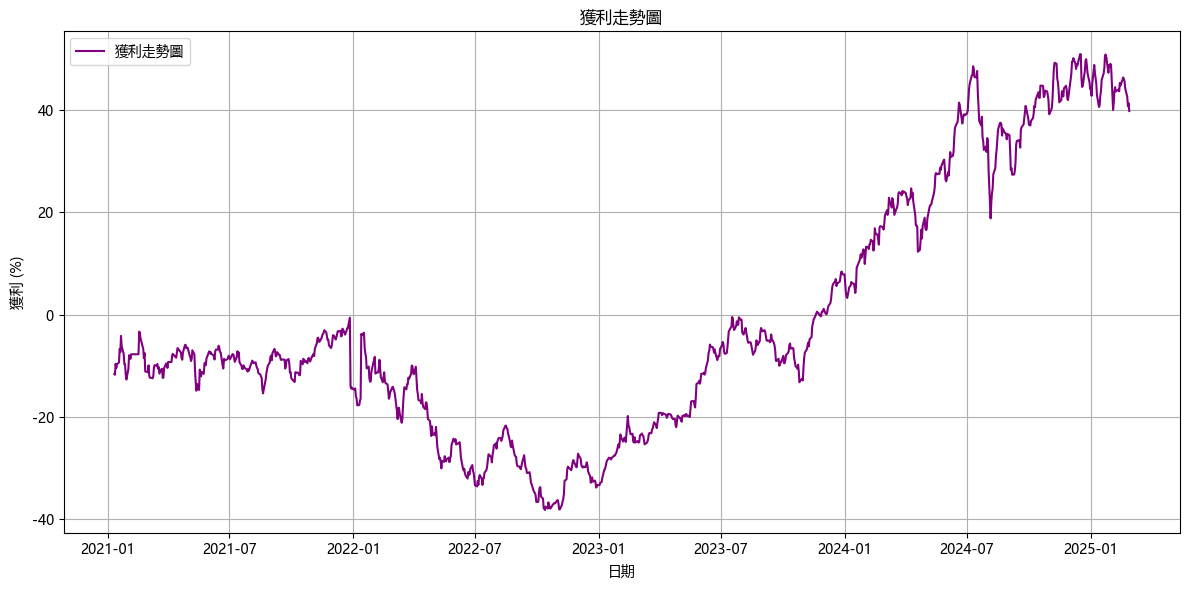

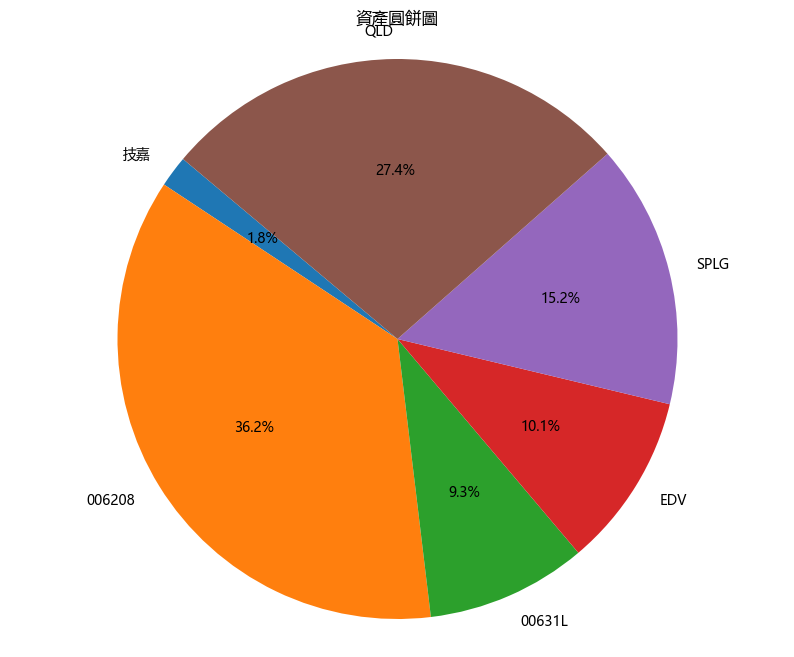

$00631L: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


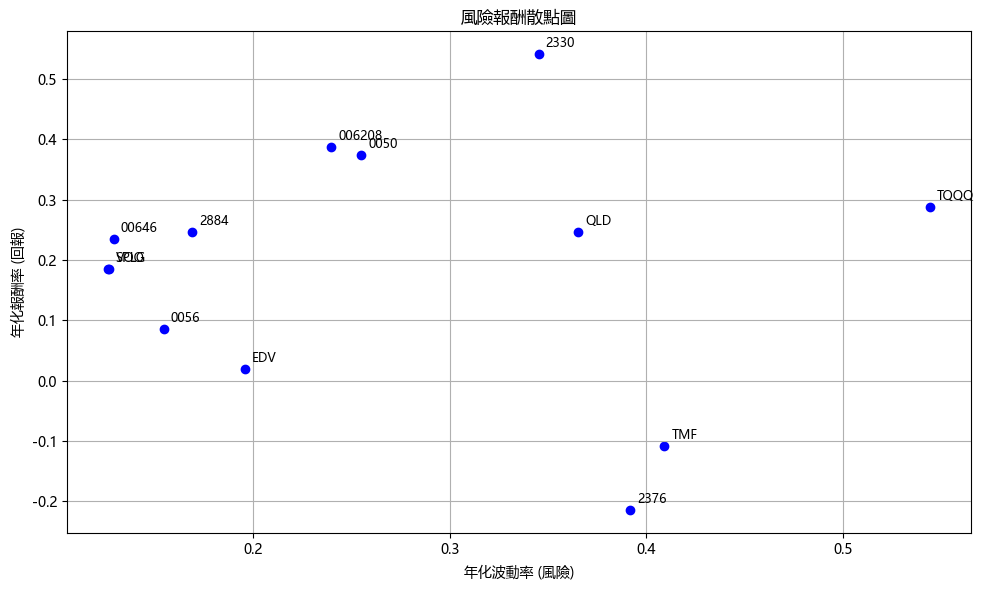

In [16]:
%run combine.py

NameError: name 'tw_result' is not defined